https://matheusfacure.github.io/python-causality-handbook/10-Matching.html

In [2]:
data_path = '../../Python_Scripts/python-causality-handbook/causal-inference-for-the-brave-and-true/'

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression

## Matching example

In [104]:
med = pd.read_csv(data_path + "./data/medicine_impact_recovery.csv")
med_ori = med.copy()
med.head()

,sex,age,severity,medication,recovery
0,0,35.049134,0.887658,1,31
1,1,41.580323,0.899784,1,49
2,1,28.127491,0.486349,0,38
3,1,36.375033,0.323091,0,35
4,0,25.091717,0.209006,0,15


__Always scale features where distance needs to be computed or regularization is used__

In [105]:
# scale features
X = ["severity", "age", "sex"]
y = "recovery"

med = med.assign(**{f: (med[f] - med[f].mean())/med[f].std() for f in X})
med.head()

,sex,age,severity,medication,recovery
0,-0.996980,0.280787,1.459800,1,31
1,1.002979,0.865375,1.502164,1,49
2,1.002979,-0.338749,0.057796,0,38
3,1.002979,0.399465,-0.512557,0,35
4,-0.996980,-0.610473,-0.911125,0,15


use the K-Nearest neighbor regression with `k=1` as a trick match each treatment with a control and a control with a treatment

In [106]:
from sklearn.neighbors import KNeighborsRegressor

treated = med.query("medication==1")
untreated = med.query("medication==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[X])),
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[X]))
])

predicted.head()

,sex,age,severity,medication,recovery,match
0,-0.996980,0.280787,1.459800,1,31,39.0
1,1.002979,0.865375,1.502164,1,49,52.0
7,-0.996980,1.495134,1.268540,1,38,46.0
10,1.002979,-0.106534,0.545911,1,34,45.0
16,-0.996980,0.043034,1.428732,1,30,39.0


Estimator: 
$
\hat{ATE} = \frac{1}{N} \sum^N_{i=0} (2T_i - 1)\big(Y_i - Y_{jm}(i)\big)
$ where $(2T_i - 1)$ is for adjusting the sign (Treatment - control). __This estimator is biased__

After controlling for confounder, medication reduces hospital stay by 1 day. However, __this estimator is baised__

In [107]:
np.mean((2*predicted["medication"] - 1)*(predicted["recovery"] - predicted["match"]))

-0.9954

Recall that if we don't control for confounding variables, medications somehow prolong recovery by 17 days. Draper 007
had a similar example of smoking and mortality if age is not blocked.

In [108]:
np.mean(predicted.query('medication == 1')['recovery']) - np.mean(predicted.query('medication == 0')['recovery'])

16.895799546498726

In [109]:
import statsmodels.formula.api as smf
smf.ols("recovery ~ medication", data=predicted).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,21.6761,0.121,178.865,0.000,21.439,21.914
medication,16.8958,0.206,82.033,0.000,16.492,17.300


In [112]:
predicted.groupby('medication').size()

medication
0    13076
1     6924
dtype: int64

### (Selection) Bias correction
__The above estimator $\hat{ATE}$:  \
Outcome for treated - Outcome for untreated = [Outcome for treated - Outcome for treated if not treated] + [Outcome for treated if not treated - Outcome for untreated]
 = Treatment Effect on the treated + Selection Bias__
 
 Therefore we need to substract the __Selection Bias__ to get the unbiased treatment effect

Bias: $
E[\sqrt{N_1}(\hat{ATET} - ATET)] = E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))] 
$ = __E[counterfactual(treated if untreated) - matched_factual (untreated)]__

Now, $\mu_0(X_i) - \mu_0(X_j(i))$ is not so simple to understand, so let's look at it more carefully. $\mu_0(X_i)$ is the outcome Y value of a treated unit $i$ had it not been treated. So, it is the counterfactual outcome $Y_0$ for unit i. $\mu_0(X_j(i))$ is the outcome of the untreated unit $j$ that is the match of unit $i$. So, it is also the $Y_0$ , but for unit $j$ now. Only this time, it is a factual outcome, because $j$ is in the non treated group. Now, because $j$ and $i$ are only similar, but not the same, this will likely not be zero. In other words, $X_i \approx X_j $. So, $Y_{0i} \approx Y_{0j} $. 

As we increase the sample size, there will be more units to match, so the difference between unit $i$ and its match $j$ will also get smaller. But this difference converges to zero slowly. As a result $E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))]$ may not converge to zero, because the $\sqrt{N_1}$ grows faster than $(\mu_0(X_i) - \mu_0(X_j(i)))$ diminishes.

Bias arises when the matching discrepancies are huge. Fortunately, we know how to correct it. Each observation contributes $(\mu_0(X_i) - \mu_0(X_j(i)))$ to the bias so all we need to do is subtract this quantity from each matching comparison in our estimator. To do so, we can replace $\mu_0(X_j(i))$ with some sort of estimate of this quantity $\hat{\mu_0}(X_j(i))$, which can be obtained with models like linear regression. This updates the ATET estimator to the following equation

$
\hat{ATET} = \frac{1}{N_1}\sum \big((Y_i - Y_{j(i)}) - (\hat{\mu_0}(X_i) - \hat{\mu_0}(X_{j(i)}))\big)
$

where $\hat{\mu_0}(x)$ is some estimative of $E[Y|X, T=0]$, like a linear regression fitted only on the untreated sample.

In [115]:
# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated, [0] is value, [1] is the matched index
treated_match_index = mt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd, [0] is value, [1] is the matched index
untreated_match_index = mt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

predicted = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X])) 
     
     # build the bias correction term 
     
     ## (predicted) treated as if untreated - (predicted) matched untreated 
     ## out of sample - in_sample
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    
    (untreated
     .assign(match=mt1.predict(untreated[X]))
     ## (predicted) untreated as if treated - (predicted) matched treated
     .assign(bias_correct=ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])))
])

predicted2 = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X])) 
     
     # build the bias correction term 
     
     ## (predicted) treated as if untreated - (predicted) matched treated (for the untreated)
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    
    (untreated
     .assign(match=mt1.predict(untreated[X]))
     
     ## (predicted) treated as if untreated - (predicted) matched treated (for the untreated)
     .assign(bias_correct=ols1.predict(treated.iloc[untreated_match_index][X]) - ols1.predict(untreated[X])))
])

predicted.head()

,sex,age,severity,medication,recovery,match,bias_correct
0,-0.996980,0.280787,1.459800,1,31,39.0,4.404034
1,1.002979,0.865375,1.502164,1,49,52.0,12.915348
7,-0.996980,1.495134,1.268540,1,38,46.0,1.871428
10,1.002979,-0.106534,0.545911,1,34,45.0,-0.496970
16,-0.996980,0.043034,1.428732,1,30,39.0,2.610159


After bias correction, the medication effect is more obvious, which reduces hospital stays by 7 days

In [10]:
np.mean((2*predicted["medication"] - 1)*((predicted["recovery"] - predicted["match"])-predicted["bias_correct"]))

-7.362660906141352

In [11]:
d1 = predicted.query('medication == 1')
d0 = predicted.query('medication == 0')

In [12]:
np.concatenate((d1['recovery'] - d1['match'] - d1['bias_correct'], d0['match'] - d0['recovery'] +  d0['bias_correct'])).mean()

-7.362660906141408

In [117]:
d11 = predicted2.query('medication == 1')
d00 = predicted2.query('medication == 0')

In [118]:
np.concatenate((d11['recovery'] - d11['match'] - d11['bias_correct'], d00['match'] - d00['recovery'] -  d00['bias_correct'])).mean()

-7.362660906141408

__bias correction could also be obtained through the doubly robust estimator__

### Using package

In [13]:
!pip3 install causalinference

In [14]:
from causalinference import CausalModel

cm = CausalModel(
    Y=med["recovery"].values, 
    D=med["medication"].values, 
    X=med[["severity", "age", "sex"]].values ## recall .values is the same as .to_numpy()
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)

C:\Users\josep\anaconda3\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -7.709      0.609    -12.649      0.000     -8.903     -6.514
           ATC     -6.665      0.246    -27.047      0.000     -7.148     -6.182
           ATT     -9.679      1.693     -5.717      0.000    -12.997     -6.361



Here ATE, ATC, and ATT standfor, respectively, average treatment effect, average treatment effect for the controls, and average treatment effect for the treated.

## Propensity score method

In [17]:
model = LogisticRegression(C=1e5).fit(med[["severity", "age", "sex"]].values, med["medication"].values)

In [18]:
pos = model.predict_proba(med[["severity", "age", "sex"]].values)[:,1] ## probability of receiving the treatment

In [19]:
med['pos'] = pos
med_ori['pos'] = pos

__We can't use this method since propensity scores are very unbalanced__

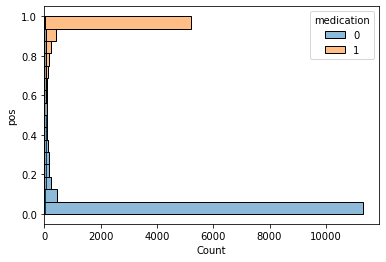

In [20]:
sns.histplot(data = med, y='pos',hue='medication');

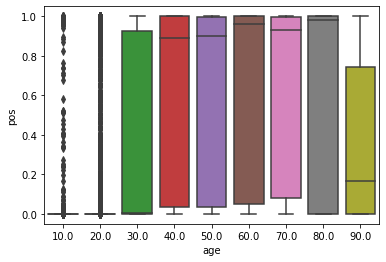

In [21]:
med_ori['age'] = np.round(med_ori['age'],-1)

sns.boxplot(data = med_ori, y='pos',x='age');

In [22]:
w1 = 1/med.query('medication==1')['pos']
w0 = 1/(1-med.query('medication==0')['pos'])
## divide by the original sample size!!! (so the counterfactual component is captured to address bias)
sum(w1 * med.query('medication==1')['recovery'])/med.shape[0] - \
sum((w0 * med.query('medication==0')['recovery']))/med.shape[0]

-2.63643186081017

__Very unbalanced, propensity score will lead to more unbalanceness__

see paper
https://gking.harvard.edu/publications/why-propensity-scores-should-not-be-used-formatching

In [23]:
print(sum(w1) ,sum(w0), med.shape[0]) ## they should be approximately equal for propensity score to work properly

10051.065813151487 15977.97153917509 20000


In [24]:
weight = ((med["medication"]-med["pos"]) /
          (med["pos"]*(1-med["pos"])))
np.mean(weight * med["recovery"])

-2.6364318608101804

## Doubly Robust Estimators

If only one of them is correct, we get similar result as if both were correct, except the bootstrap variance is higher.

In [10]:
data = pd.read_csv(data_path + "./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


In [12]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [27]:
temp_name = 'medication'

med.query(f'{temp_name}==1')

,sex,age,severity,medication,recovery,pos
0,-0.996980,0.280787,1.459800,1,31,0.998795
1,1.002979,0.865375,1.502164,1,49,0.999985
7,-0.996980,1.495134,1.268540,1,38,0.993040
10,1.002979,-0.106534,0.545911,1,34,0.879452
16,-0.996980,0.043034,1.428732,1,30,0.998367
...,...,...,...,...,...,...
19982,1.002979,0.444150,1.667773,1,48,0.999997
19988,1.002979,-0.736709,0.227483,1,28,0.258804
19989,1.002979,1.002589,0.326361,1,39,0.489000
19993,1.002979,1.627845,0.920818,1,49,0.996342


In [26]:
def doubly_robust(df, X, T, Y, n_runs = 1, bootstrap = False):
    out = np.zeros(n_runs)
    if bootstrap:
        df = df.sample(frac=1,replace=True)
    for i in range(n_runs):
        ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
        mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
        mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
        out[i] = np.mean(df[T]*(df[Y] - mu1)/ps + mu1) - np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    return(out)

In [28]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y,1)

array([0.38820054])

In [30]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates).reshape(-1)

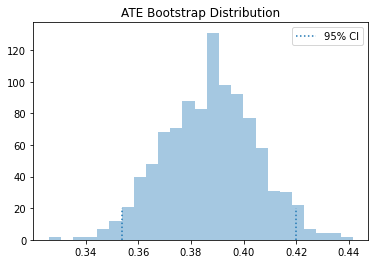

In [37]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Example where Propensity score works

In [4]:
data = pd.read_csv(data_path + "./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


In [5]:
data.groupby('intervention').size()

intervention
0    7007
1    3384
dtype: int64

__counfounding variable__: obviously, students have higher expectation will visit the seminar

In [14]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

In [13]:
data.groupby("intervention")["achievement_score"].mean()

intervention
0   -0.153803
1    0.318469
Name: achievement_score, dtype: float64

__difference of Standardized variable is deviation__:

For example normal distribution of 1.96 and 0 and 2 std deviation.

In [15]:
data['achievement_score'].describe() ## the score is standardized

count    1.039100e+04
mean     1.324073e-16
std      1.000000e+00
min     -3.111431e+00
25%     -7.033152e-01
50%     -3.449486e-02
75%      6.724723e-01
max      3.563639e+00
Name: achievement_score, dtype: float64

<AxesSubplot:xlabel='achievement_score', ylabel='Count'>

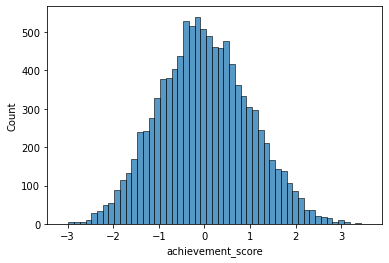

In [17]:
sns.histplot(data['achievement_score'])

In [59]:
import statsmodels.formula.api as smf
smf.ols("achievement_score ~ (intervention)", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


In [94]:
n = 10000
mask = np.random.choice(2,size=n)
y = TE * mask + np.random.normal(size = n)
xy_df = pd.DataFrame({"y":y,"x":mask})

In [95]:
smf.ols('y~x',data = xy_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0182,0.014,-1.275,0.202,-0.046,0.010
x,5.0256,0.020,248.908,0.000,4.986,5.065


In [101]:
np.mean(xy_df.query('x==1')['y']) - np.mean(xy_df.query('x==0')['y'])

5.025587889019991

In [96]:
xy_df = xy_df.assign(y_sd = lambda x: (x['y'] - x['y'].mean())/x['y'].std())

In [97]:
smf.ols('y_sd~x',data = xy_df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.9299,0.005,-176.198,0.000,-0.940,-0.920
x,1.8558,0.007,248.908,0.000,1.841,1.870


In [100]:
np.mean(xy_df.query('x==1')['y_sd']) - np.mean(xy_df.query('x==0')['y_sd'])

1.8557654512264934

# DID

In order to figure out how good billboards were as a marketing channel, we placed 3 billboards in the city of Porto Alegre, the capital of the state of Rio Grande do Sul. We wanted to see if that boosted deposits into our savings account. As a note for those not very familiar with Brazilian geography, Rio Grande do Sul is part of the south of the country, one of the most developed regions.

Having this in mind, we decided to also look at data from another capital from the south, Florianopolis, the capital city of the state of Santa Catarina. The idea is that we could use Florianopolis as a control sample to estimate the counterfactual  when compared to Porto Alegre. We placed the billboard in Porto Alegre for the entire month of June. 

Remember that deposits are our outcome variable, the one we wish to increase with the billboards. POA is a dummy indicator for the city of Porto Alegre. When it is zero, it means the samples are from Florianopolis. Jul is a dummy for the month of July, or for the post intervention period. When it is zero it refers to samples from May, the pre-intervention period.

In [17]:
data_path

'../../Python_Scripts/python-causality-handbook/causal-inference-for-the-brave-and-true/'

In [30]:
data = pd.read_csv(data_path + "data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


$DID = (Y_{t,1} - Y_{c,1}) - (Y_{t,0} - Y_{c,0}) $

In [32]:
DID = (data.query('poa == 1 and jul ==1')['deposits'].mean() - data.query('poa == 0 and jul ==1')['deposits'].mean()) -\
       (data.query('poa == 1 and jul ==0')['deposits'].mean() - data.query('poa == 0 and jul ==0')['deposits'].mean())
DID

6.524557692307695

In [34]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

fl_after = data.query("poa==0 & jul==1")["deposits"].mean()

fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

In [36]:
(poa_after-fl_after)-(poa_before-fl_before)

6.524557692307695

__Very small treatment effect: $6.52/customer increase by setting up the bill boards__

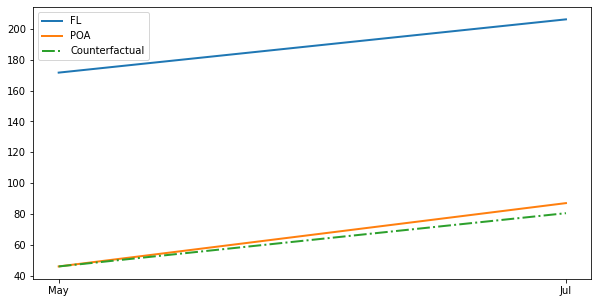

In [15]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

__regression with the interaction gives the same effect__

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

__Notice that $\beta_0$ is the baseline of the control. In our case, is the level of deposits in Florianopolis in the month of May. If we turn on the treated city dummy, we get $\beta_1$. So $\beta_0 + \beta_1$ is the baseline of Porto Alegre in May, before the intervention, and $\beta_1$ is the increase of Porto Alegre baseline on top of Florianopolis. If we turn the POA dummy off and turn the July dummy on, we get $\beta_0 + \beta_2$, which is the level of Florianópolis in July, after the intervention period. $\beta_2$ is then the trend of the control, since we add it on top of the baseline to get the level of the control at the period post intervention. As a recap, $\beta_1$ is the increment we get by going from the control to the treated, $\beta_2$ is the increment we get by going from the period before to the period after the intervention. Finally, if we turn both dummies on, we get $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ is the level in Porto Alegre after the intervention. So $\beta_3$ is the incremental impact when you go from May to July and from Florianopolis to POA. In other words, it is the Difference in Difference estimator.__

In [16]:
import statsmodels.formula.api as smf
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Non Parallel Trends

One obvious problem with Diff-in-Diff is failure to satisfy the parallel trend assumption. If the growth trend from the treated is different from the trend of the control, diff-in-diff will be biased. This is a common problem with non-random data, where the decision to treat a region is based on its potential to respond well to the treatment, or when the treatment is targeted at regions that are not performing very well. Take our marketing example. We decided to test billboards in Porto Alegre not in order to check the effect of billboards in general. __The reason is simply because sales perform poorly there. Perhaps online marketing is not working there. In this case, it could be that the growth we would see in Porto Alegre without a billboard would be lower than the growth we observe in other cities. This would cause us to underestimate the effect of the billboard there.__

__One way to check if this is happening is to plot the trend using past periods before the intervention (billboard).__ For example, let's suppose POA had a small decreasing trend but Florianopolis was on a steep ascent. In this case, showing periods from before would reveal those trends and we would know Diff-in-Diff is not a reliable estimator.

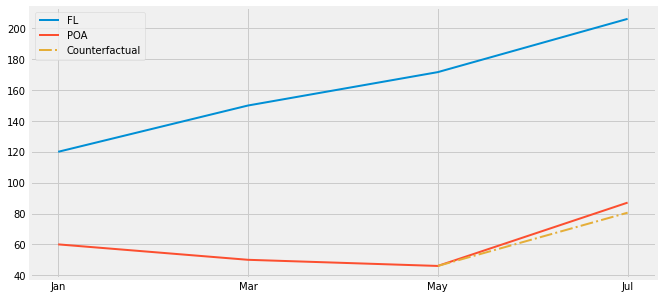

In [18]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

__We will see how to solve this problem with synthetic control. It will use multiple cities to create a synthetic city that closely follows the trend of the city of interest. But for now, remember that you always need to check if you have parallel trends when applying diff-in-diff.__

One final issue that it's worth mentioning is that you won't be able to place confidence intervals around your Diff-in-Diff estimator if you only have aggregated data. Say for instance you don't have data on what each of our customers from Florianópolis or Porto Alegre did. Instead, you only have the average deposits before and after the intervention for both cities. In this case, you will still be able to estimate the causal effect by Diff-in-Diff, but you won't know the variance of it. That's because all the variability in your data got squashed out in aggregation.

__Recall in the data above in which we have data on each customer, we could estimate the CI__



## Synthetic control

__One Amazing Math Trick to Learn What can’t be Known__

When we looked at difference-in-difference, we had data on multiple customers from 2 different cities: Porto Alegre and Florianopolis. The data span 2 different time periods: before and after a marketing intervention was done in Porto Alegre to boost customer deposits. To estimate the treatment effect, we ran a regression that gave us the difference-in-difference estimator and its standard error. 

For that case, we had a lot of samples, because data was disaggregated. But what if all we have is aggregated data on the city level? For instance, let's pretend all we have is the average level of deposits in both cities before and after the intervention.

|city|before|after|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

We would still be able to compute the Diff-in-Diff estimator 

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$

__However, note that the sample size here is 4, which is also the number of parameters in our Diff-in-Diff models. In this case, the standard error is not well defined, so what should we do? Another problem is that Florianopolis might not be as similar to Porto Alegre as we would want to.__ For instance, Florianopolis is known for its beautiful beaches and easy going people while Porto Alegre is more famous for its barbecue and prairies. The problem here is that you can't ever know for sure if you are using an appropriate control group.

To work around this, we will use what is known as [**"the most important innovation in the policy evaluation literature in the last few years"**](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3), Synthetic Controls. It is based on a simple, yet powerful idea. We don't need to find any single unit in the untreated that is very similar to the treated. Instead, we can forge our own as a combination of multiple untreated units, creating what is effectively a synthetic control. Synthetic control is so effective yet so intuitive that it even got an article published, not on a scientific journal, but on the [Washington Post](https://www.washingtonpost.com/news/wonk/wp/2015/10/30/how-to-measure-things-in-a-world-of-competing-claims/).

In [31]:
cigar = (pd.read_csv(data_path + "data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


We have `state` as the state index, where California is the number 3. Our covariates are `retprice`, the cigarette retail price, and `cigsale`, the per-capita sales of cigarettes in packs. Our outcome variable of interest is `cigsale`. Finally, we have boolean helper variables to signal the state of California and the post intervention period (after Prop 99). If we plot the sales of cigarettes for California and other states across time, this is what we would get.

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

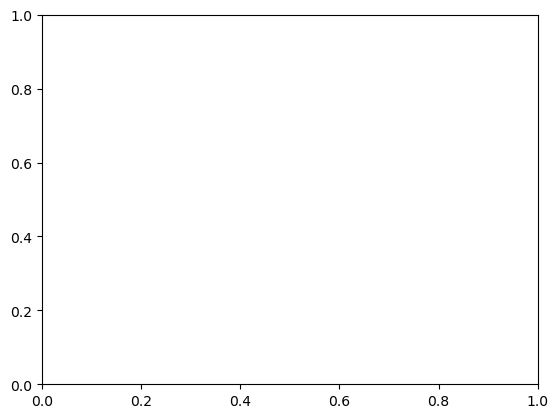

In [33]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

__Both Response and features are weighted for the Synthetic control__

In [35]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

In [37]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [39]:
from sklearn.linear_model import LinearRegression, ElasticNet
model = LinearRegression(fit_intercept=False).fit(X, y)
weights_lr = model.coef_
## weight that minimized the MSE between California and the sythetic control + convariates
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

__despite we trained our weights using both `cigsale` and `retprice`, we shouldn't use `retprice` for prediction since prop 99 affects this variable?__

In [42]:
post_inter_X = cigar.query("~california").pivot(index='year', columns="state")["cigsale"]
post_inter_X

state,1,2,4,5,6,7,8,9,10,11,...,30,31,32,33,34,35,36,37,38,39
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003
1975,111.699997,114.800003,131.000000,110.199997,147.600006,122.900002,123.300003,131.800003,162.399994,120.500000,...,130.500000,113.500000,117.400002,116.000000,75.800003,155.500000,152.699997,123.199997,113.500000,160.699997
1976,116.199997,119.099998,134.199997,113.400002,153.000000,125.900002,125.099998,134.399994,166.600006,124.400002,...,136.800003,116.699997,121.699997,121.400002,77.900002,171.100006,158.100006,129.699997,115.400002,161.500000
1977,117.099998,122.599998,132.000000,117.300003,153.300003,127.900002,125.000000,134.000000,173.000000,125.500000,...,137.199997,115.599998,124.599998,124.199997,78.000000,169.399994,157.699997,133.899994,117.199997,160.399994
1978,123.000000,127.300003,129.199997,117.500000,155.500000,130.600006,122.800003,136.699997,150.899994,127.099998,...,140.399994,116.900002,127.300003,126.599998,79.599998,162.399994,155.899994,131.600006,116.699997,160.300003


In [44]:
calif_synth_lr = post_inter_X.values.dot(weights_lr)
calif_synth_lr

array([123.        , 121.        , 123.5       , 124.40000153,
       126.69999695, 127.09999847, 128.        , 126.40000153,
       126.09999847, 121.90000153, 120.19999695, 118.59999847,
       115.40000153, 110.80000305, 104.80000305, 102.80000305,
        99.69999695,  97.5       ,  90.09999847,  92.07147552,
       102.7210304 ,  93.1500545 ,  76.61895546, 107.5980029 ,
       105.8377827 ,  98.39453838, 112.84481194, 101.7323058 ,
        73.01922051,  87.1804984 ,  72.83188875])

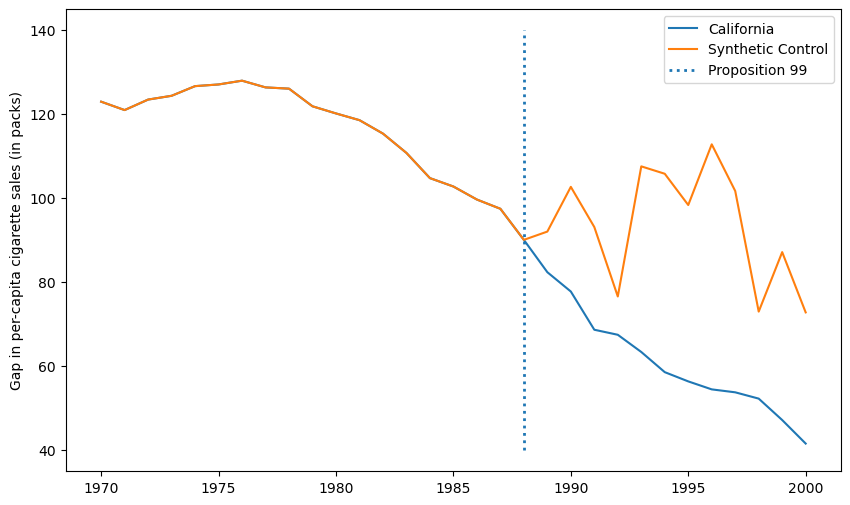

In [46]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

If we think about why this is happening, remember that we have 38 states in our donor pool. So our linear regression has 38 parameters to play with in order to make the pretreatment pool match the treatment as close as it can. This is the case where, even if T is large, N is also large, which gives too much flexibility to our linear regression model. __If you are familiar with regularized models, know that you could use Ridge or Lasso regression to fix this. Here, we will look at another more traditional way to avoid overfitting. However, penalized regression still won't resolve the extrapolation problem!!!! (eg., negative weights for sales don't make sense), hence we will use interpolation__

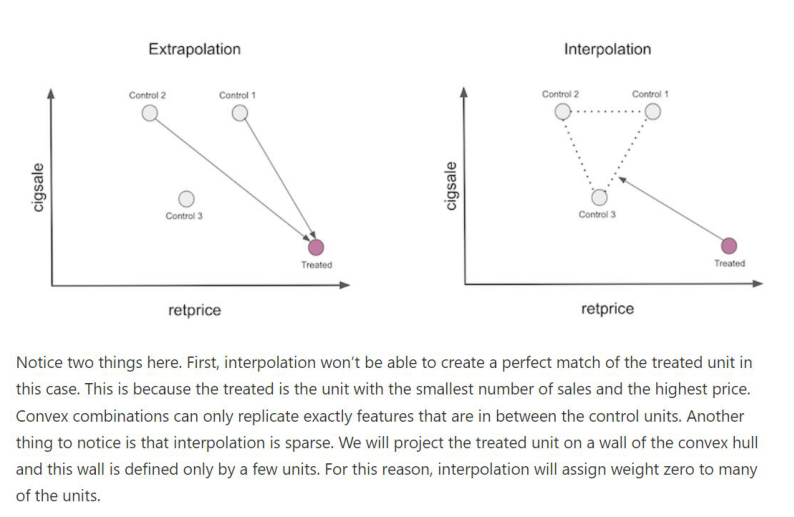

In [49]:

from PIL import Image

# Load the image
image_path = './images/interpolation_extrapolation.JPG'  # Replace with your image path
img = Image.open(image_path)

# Display the image
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()

### interpolation

Solution: Constrain optimization with weights to be strickly positive and between 0 and 1 and sum to 1. In addition, negative price and sales are almost impossible in practice.

In [52]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [54]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         ## sum to 1 
                         f_eqcons=lambda x: np.sum(x) - 1,
                         
                         ## weight between 0 and 1
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [56]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000257


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [76]:
from sklearn.linear_model import Lasso, ElasticNet
lasso = Lasso(alpha=10, positive=True)

In [78]:
model = lasso.fit(X,y)

In [80]:
model.coef_

array([0.        , 0.        , 0.06995609, 0.08175251, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01595597, 0.        , 0.13722017,
       0.12544177, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.45505963, 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [17]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

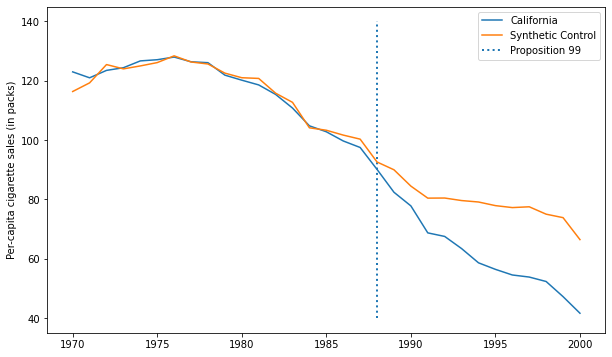

In [18]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

__Treatment effect__

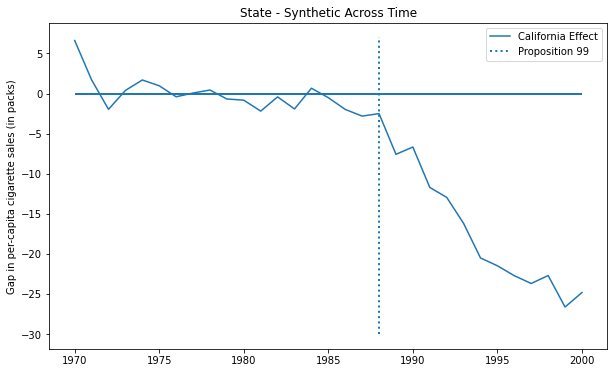

In [19]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

By the year 2000, it looks like Proposition 99 has reduced the sales in cigarettes by 25 packs. That is very cool and all, but something you might be asking yourself is: __how can I know if this is statistically significant?__

__permutation test__

In [27]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [29]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

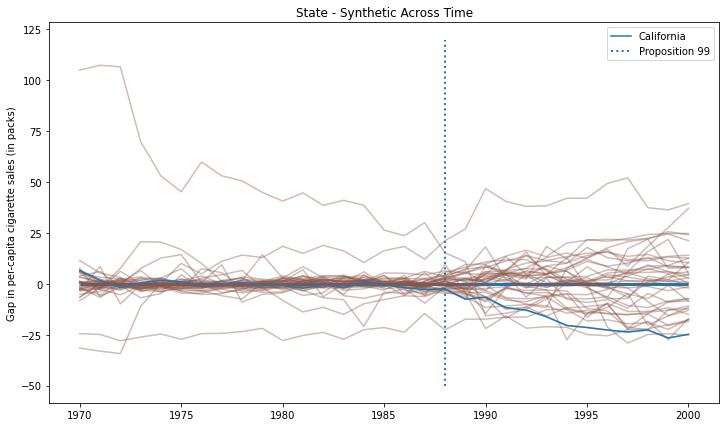

In [37]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

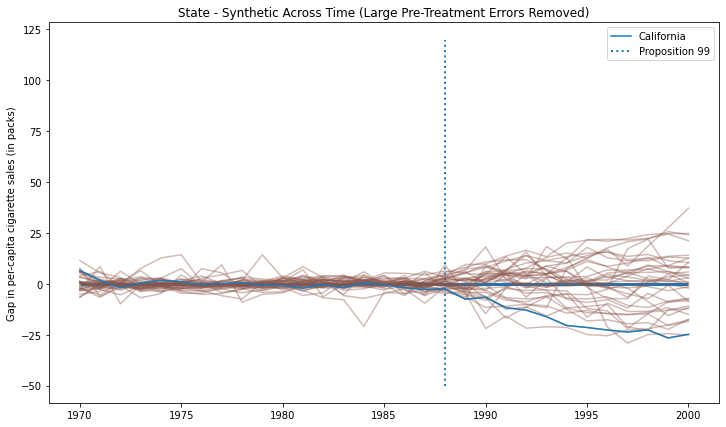

In [38]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

Removing the noise, we can see how extreme of a value is the effect in the state of California. This image shows us that if we pretend the treatment had happened to any other state, we would almost never get an effect so extreme as the one we got with California.

if we want to test the one sided hypothesis that the effect in California is below zero, we can estimate the P-value as the proportion of times the effect in California is bigger than all the estimated effects.

__P-value for year 2000__

In [39]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.830159726635777


array([  5.79715876,   0.89458993, -24.83015973,  -7.16628117,
       -10.9220487 ,  37.11640556, -15.06971715,  -0.49805123,
       -18.45795075,  21.13366442,  12.57782778,  -1.47547825,
        10.49627382, -11.67012364,   4.29850836,   8.0481141 ,
        14.02322401,   8.2500273 ,   0.32576357,  -8.40826908,
        -2.12402698,  -7.4286503 ,   2.9615756 ,  24.1047813 ,
         4.25211766, -17.75844573,   7.93334015,   2.81640134,
        12.64955971, -17.47677513, -25.16040942, -12.26469132,
        24.69067414,  10.36299564,  -8.59880351])

In [40]:
np.mean(np.array(effects) < calif_effect) ## significant

0.02857142857142857

## LATE Effect

In [23]:
!pip install linearmodels, graphviz

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 2.0 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.7 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 13.2 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------------- ---------------------- 1.2/2.8 MB 37.8 MB/s eta 0:00:01
   ---------------------------- ----------- 2.0/2.8 MB 31.2 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 22.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/94.5 kB ? eta -:--:--
   ---------------------------------------- 94.5/94.5 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
   ---------------------------------------- 43.7/43.7 kB ? eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr


In [49]:
%matplotlib inline

style.use("fivethirtyeight")

In [33]:
data = pd.read_csv(f"{data_path}/data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


### Model them as independent variable 

In [35]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


### Model them in two stages

In [37]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0000,4.88e-10,0.0000,1.0000,-9.566e-10,9.566e-10
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


In [39]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


__LATE__
- Two-stage model:

push_delivered = $\alpha_1$ + $\beta_1$ * push_assigned + $\epsilon$

app_purhace =  $\alpha_2$ + $\beta_2$ * push_delivered + $\epsilon$


- combines above into a one-stage model

app_purhace =  $\alpha_3$ + $\beta_3$ * push_assigned  + $\epsilon$ where $\beta_3 = \beta_2$ * $\beta_1$ 

=> $\beta_2$ =  $\frac{\beta_3} {\beta_1} = \frac{2.3636}{0.7176} = 3.2938$ 

### Combine them together will get the same result

In [107]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


### Recognize above is just hiearchical model

push_delivered = $\alpha_1$ + $\beta_1$ * push_assigned + $\epsilon$

app_purhace =  $\alpha_2$ + $\beta_2$ * push_delivered + $\epsilon$

In [61]:
import statsmodels.api as sm

# Model 1: Push Delivered ~ Push Assigned
X1 = sm.add_constant(data['push_assigned'])
y1 = data['push_delivered']
model_1 = sm.OLS(y1, X1).fit()

# Get the predicted push_delivered
data['predicted_push_delivered'] = model_1.predict(X1)

# Model 2: In-App Purchase ~ Push Delivered (using predicted from Model 1)
X2 = sm.add_constant(data['predicted_push_delivered'])
y2 = data['in_app_purchase']
model_2 = sm.OLS(y2, X2).fit()


In [79]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         push_delivered   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                 1.285e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:08:59   Log-Likelihood:                -2685.2
No. Observations:               10000   AIC:                             5374.
Df Residuals:                    9998   BIC:                             5389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.428e-16      0.004   3.21e-14      1.000      -0.009       0.009
push_assigned     0.7176      0.006    113.342      0.000       0.705       0.730
==============================================================================
Omnibus:                     2032.205   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3498.233
Skew:                          -1.375   Prob(JB):                         0.00
Kurtosis:                       3.913   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        in_app_purchase   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     20.60
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           5.74e-06
Time:                        11:09:10   Log-Likelihood:                -46784.
No. Observations:               10000   AIC:                         9.357e+04
Df Residuals:                    9998   BIC:                         9.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       69.2917      0.366    189.234      0.000      68.574      70.009
predicted_push_delivered     3.2938      0.726      4.538      0.000       1.871       4.717
==============================================================================
Omnibus:                      908.959   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1262.774
Skew:                           0.740   Prob(JB):                    6.19e-275
Kurtosis:                       3.917   Cond. No.                         3.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""